# Chương 07. Detecting Shapes and Segmenting an Image

- Trong chương này, chúng ta sẽ tìm hiểu về phân tích hình dạng và phân đoạn hình ảnh. 
- Chúng ta sẽ học cách nhận biết hình dạng và ước tính ranh giới chính xác. 
- Chúng ta sẽ thảo luận về cách phân đoạn một hình ảnh thành các bộ phận cấu thành của nó bằng các phương pháp khác nhau. - - Chúng ta cũng sẽ học cách tách tiền cảnh khỏi nền.

## Đến cuối chương này, bạn sẽ biết:
    - Phân tích đường viền và hình dạng phù hợp là gì ?
    - Làm thế nào để phù hợp với hình dạng ?
    - Phân đoạn hình ảnh là gì ?
    - Làm thế nào để phân đoạn một hình ảnh thành các bộ phận cấu thành của nó
    - Cách tách tiền cảnh khỏi nền
    - Cách sử dụng các kỹ thuật khác nhau để phân đoạn một hình ảnh

## Nội dung:
1. **Contour analysis and shape matching**
2. **Approximating a contour**
3. **Identifying a pizza with a slice taken out**
4. **How to censor a shape?**
5. **What is image segmentation?**
6. **Watershed algorithm**

## 1. Contour analysis and shape matching (Phân tích đường viền và hình dạng phù hợp)

- Phân tích đường viền xung quanh là một công cụ rất hữu ích trong lĩnh vực thị giác máy tính.
- Chúng ta xử lý rất nhiều hình dạng trong thế giới thực và phân tích đường viền giúp phân tích các hình dạng đó bằng các thuật toán khác nhau.
- Khi chúng ta chuyển đổi một hình ảnh thành thang độ xám và **threshold** nó, chúng ta sẽ có một loạt các đường và đường viền xung quanh. Khi chúng ta hiểu các thuộc tính của các hình dạng khác nhau, chúng ta sẽ có thể trích xuất thông tin chi tiết từ một hình ảnh.

- Giả sử chúng ta muốn xác định hình dạng boomerang trong hình ảnh sau:

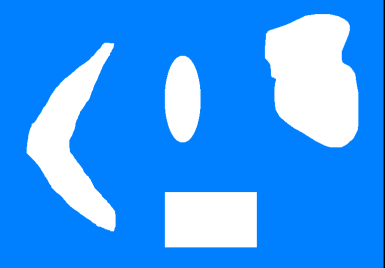

- Để làm được điều đó, trước tiên chúng ta cần biết một chiếc boomerang thông thường trông như thế nào:

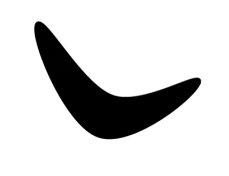

- Bây giờ, sử dụng hình ảnh trên làm "tài liệu tham khảo", chúng ta có thể xác định hình dạng nào trong hình ảnh gốc của chúng ta tương ứng với boomerang không ?
- Nếu bạn để ý, chúng ta không thể sử dụng cách tiếp cận dựa trên tương quan một cách đơn giản vì tất cả các hình dạng đều bị biến dạng.
- Điều này có nghĩa là một cách tiếp cận mà chúng ta tìm kiếm một phù hợp đến chính xác sẽ khó có hiệu quả!
- Chúng ta cần hiểu các đặc trưng của hình dạng và matching các đặc trưng tương ứng để xác định hình dạng boomerang.
- OpenCV cung cấp một số tiện ích matching hình dạng mà chúng ta có thể sử dụng để đạt được điều này. Nếu bạn muốn biết thêm, hãy truy cập: https://docs.opencv.org/3.3.0/dc/dc3/tutorial_py_matcher.html để biết thêm nhé !

- Matching (so khớp) dựa trên khái niệm **Hu** khoảnh khắc, có liên quan đến khoảnh khắc hình ảnh (image moments). Bạn có thể tham khảo bài viết sau để tìm hiểu thêm về moments (những khoảnh khắc): http://zoi.utia.cas.cz/files/chapter_moments_color1.pdf 
 - Khái niệm về *image moments* về cơ bản đề cập đến tổng các weighted và power-raise của các pixel trong một hình dạng (shape).

### $$I=\sum^N _{i=0} w_i p^k _i$$

- Ở phương trình trên, $p$ đề cập đến các pixel bên trong đường viền, $w$ đề cập đến các trọng số, N đề cập đến số điểm bên trong đường viền, $k$ đề cập đến power và tôi đề cập đến thời điểm. Tùy thuộc vào các giá trị, chúng ta chọn $w$ và $k$, sao cho có thể trích xuất các đặc trưng khác nhau từ đường viền đó.

- Có lẽ ví dụ đơn giản nhất là tính diện tích phần nằm bên trong đường viền.
- Để làm điều này, chúng ta cần đếm số pixel trong vùng đó. Vì vậy, về mặt toán học, ở dạng tổng có weighted và power-raise, chúng ta chỉ cần đặt w bằng 1 và k bằng 0.
- Điều này sẽ cho chúng ta diện tích của đường viền. Tùy thuộc vào cách chúng ta tính toán những moment này, nó giúp chúng ta hiểu được những hình dạng khác nhau này. Điều này cũng làm phát sinh một số tính chất thú vị giúp chúng ta xác định số liệu tương tự như hình dạng.

- Nếu chúng ta matching với các hình dạng, bạn sẽ thấy được điều như sau:

- Chúng ta hãy xem đoạn code để làm điều này:

In [ ]:
import cv2
import numpy as np

# Extract all the contours from the image
def get_all_contours(img):
    ref_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(ref_gray, 127, 255, 0)
    
    # Find all the contours in the thresholded image. The values
    # for the second and third parameters are restricted to a
    # certain number of possible values.
    im2, contours, hierarchy= cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    return contours

# Extract reference contour from the image
def get_ref_contour(img):
    contours = get_all_contours(img)
    
    # Extract the relevant contour based on area ratio. We use the
    # area ratio because the main image boundary contour is
    # extracted as well and we don't want that. This area ratio
    # threshold will ensure that we only take the contour inside the image.
    for contour in contours:
        area = cv2.contourArea(contour)
        img_area = img.shape[0] * img.shape[1]
        if 0.05 < area/float(img_area) < 0.8:
            return contour

if __name__=='__main__':
    # Boomerang reference image
    img1 = cv2.imread('boomerang.png')
    
    # Input image containing all the different shapes
    img2 = cv2.imread('shape.png')
    
    # Extract the reference contour
    ref_contour = get_ref_contour(img1)
    
    # Extract all the contours from the input image
    input_contours = get_all_contours(img2)
    
    closest_contour = None
    min_dist = None
    contour_img = img2.copy()
    cv2.drawContours(contour_img, input_contours, -1, color=(0,0,0), thickness=3)
    cv2.imshow('Contours', contour_img)
    
    # Finding the closest contour
    for contour in input_contours:
        # Matching the shapes and taking the closest one using
        # Comparison method CV_CONTOURS_MATCH_I3 (second argument)
        ret = cv2.matchShapes(ref_contour, contour, 3, 0.0)
        print("Contour %d matchs in %f" % (i, ret))
        if min_dist is None or ret < min_dist:
            min_dist = ret
            closest_contour = contour
       
    cv2.drawContours(img2, [closest_contour], 0 , color=(0,0,0), thickness=3)
    cv2.imshow('Best Matching', img2)
    cv2.waitKey()

- Việc sử dụng phương thức **matchShapes** có thể khác với bảo toàn **Hu** (CV_CONTOUR_MATCH_I1,2,3), trong đó mỗi phương thức có thể tạo ra kết quả phù hợp nhất với các hình dạng khác nhau do kích thước, định hướng hoặc xoay của các đường viền. Để tìm hiểu thêm, bạn có thể kiểm tra tài liệu chính thức tại: https://docs.opencv.org/3.3.0/d3/dc0/group__imgproc__shape.html

## 2. Approximating a contour (Xấp xỉ một đường viền)

- ất nhiều đường viền mà chúng ta gặp trong đời thực bị nhiễu. Điều này có nghĩa là các đường viền trông không được trơn tru và do đó phân tích của chúng ta bị ảnh hưởng.
- Vì vậy, làm thế nào để chúng ta đối phó với điều này? Một cách để làm điều này sẽ là lấy tất cả các điểm trên đường viền và sau đó xấp xỉ nó với một đa giác mịn.

- Hãy xem xét hình ảnh boomerang một lần nữa. Nếu bạn ước tính các đường viền bằng các ngưỡng khác nhau, bạn sẽ thấy các đường viền thay đổi hình dạng của chúng. Hãy bắt đầu với hệ số 0,05:

- Nếu bạn giảm yếu tố này, các đường viền sẽ trở nên mượt mà hơn. Với hệ số là 0.01:

- Nếu bạn làm cho nó thực sự nhỏ, giả sử 0,00001, thì nó sẽ trông giống như hình ảnh gốc:

- Đoạn code sau đây trình bày cách chuyển đổi các đường viền đó thành độ mịn gần đúng của đa giác:

In [ ]:
import sys
import cv2
import numpy as np

if __name__=='__main__':
    # Input image containing all the different shapes
    img1 = cv2.imread('shape.png')
    
    # Extract all the contours from the input image
    input_contours = get_all_contours(img1)
    contour_img = img1.copy()
    smoothen_contours = []
    factor = 0.05
    
    # Finding the closest contour
    for contour in input_contours:
        epsilon = factor * cv2.arcLength(contour, True)
        smoothen_contours.append(cv2.approxPolyDP(contour, epsilon, True))
        
    cv2.drawContours(contour_img, smoothen_contours, -1, color=(0,0,0), thickness=3)
    cv2.imshow('Contours', contour_img)
    cv2.waitKey

## 3. Identifying a pizza with a slice taken out (Xác định một chiếc bánh pizza với một lát được lấy ra)

- Xác định một chiếc bánh pizza với một lát được lấy ra. Tiêu đề có thể hơi sai lệch, bởi vì chúng ta sẽ không nói về những lát bánh pizza. Nhưng giả sử bạn đang ở trong một tình huống mà bạn có một hình ảnh chứa các loại pizza khác nhau với các hình dạng khác nhau. Bây giờ, ai đó đã lấy một lát ra khỏi một trong những chiếc pizza đó. Làm thế nào chúng ta sẽ tự động xác định điều này?

- Chúng ta không thể thực hiện phương pháp mà chúng ta đã thực hiện trước đó vì chúng ta không biết hình dạng trông như thế nào, vì vậy chúng ta không có bất kỳ hình mẫu nào.
- Chúng ta thậm chí không chắc chắn hình dạng mà chúng ta đang tìm kiếm, vì vậy chúng ta không thể xây dựng một mẫu dựa trên bất kỳ thông tin trước. Tất cả những gì chúng ta biết thực tế là một lát đã được lấy từ một trong những chiếc pizza. Hãy xem xét hình ảnh sau đây:

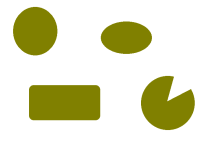

- Nó không chính xác là một hình ảnh thực sự, nhưng bạn có ý tưởng. Bạn biết những gì chúng ta đang nói về hình dạng. Vì chúng ta không biết những gì chúng ta đang tìm kiếm, chúng ta cần sử dụng một số thuộc tính của những hình dạng này để xác định bánh pizza cắt lát. Nếu bạn nhận thấy, tất cả các hình dạng đều có dạng đóng ; nghĩa là, bạn có thể lấy bất kỳ hai điểm nào trong các hình đó và vẽ một đường thẳng giữa chúng và đường thẳng đó sẽ luôn nằm trong hình đó. Những loại hình dạng này được gọi là **hình dạng lồi (convex shape)**.

- Nếu bạn nhìn vào hình dạng bánh pizza được cắt lát, chúng ta có thể chọn hai điểm sao cho đường kẻ giữa chúng nằm ngoài hình dạng, như trong hình sau:

- Vì vậy, tất cả những gì chúng ta cần làm là phát hiện hình dạng không lồi trong ảnh. Đoạn code dưới đây thực hiện việc detect đó:

In [ ]:
import sys
import cv2
import numpy as np

if __name__=='__main__':
    img = cv2.imread('pizza.png')
    
    # Iterate over the extracted contours
    # Using previous get_all_contours() method
    for contour in get_all_contours(img):
        # Extract convex hull from the contour
        hull = cv2.convexHull(contour, returnPoints=False)
        
        # Extract convexity defects from the above hull
        # Being a convexity defect the cavities in the hull segments
        defects = cv2.convexityDefects(contour, hull)
        
        if defects is None:
            continue
            
        # Draw lines and circles to show the defects
        for i in range(defects.shape[0]):
            start_defect, end_defect, far_defect, _ = defects[i,0]
            start = tuple(contour[start_defect][0])
            end = tuple(contour[end_defect][0])
            far = tuple(contour[far_defect][0])
            cv2.circle(img, far, 5, [128,0,0], -1)
            cv2.drawContours(img, [contour], -1, (0,0,0), 3)
    
    cv2.imshow('Convexity defects',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

- Để tìm hiểu thêm về cách hoạt động của *convexityDetects*, đọc thêm tại: https://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html#convexitydefects

- Nếu bạn chạy code trên, bạn sẽ thấy một cái gì đó như thế này:

- Đợi một chút, chuyện gì đã xảy ra ở đây? Trông thật bừa bộn. Có phải chúng ta đã làm gì sai? Hóa ra, các đường cong không thực sự trơn tru. Nếu bạn quan sát kỹ, có những đường vân nhỏ ở khắp mọi nơi dọc theo các đường cong. Vì vậy, nếu bạn chỉ chạy **ConvexityDetect**, nó sẽ không hoạt động.

- Vì thế, xấp xỉ đường viền (contour approximation) được apply trong ngữ cảnh này.
- Khi chúng ta đã phát hiện các đường viền, chúng ta cần làm mịn chúng để các đường này vân không ảnh hưởng đến chúng.

In [ ]:
factor = 0.01
epsilon = factor * cv2.arcLength(contour, True)
contour = cv2.approxPolyDP(contour, epsilon, True)

- Nếu bạn chạy đoạn code trên bằng cách sử dụng các đường viền làm mịn, output sẽ trông như sau:

### How to censor a shape? (Làm thế nào để kiểm duyệt một hình dạng?)

- Giả sử bạn đang xử lý hình ảnh và bạn muốn chặn một hình dạng cụ thể. Bây giờ, bạn có thể nói rằng bạn sẽ sử dụng kết hợp hình dạng để xác định hình dạng và sau đó chỉ cần chặn nó, phải không ? Nhưng vấn đề ở đây là chúng ta không có bất kỳ mẫu nào có sẵn. Vì vậy, làm thế nào để chúng ta đi về làm điều này ? Phân tích hình dạng có nhiều dạng khác nhau và chúng ta cần xây dựng thuật toán tùy theo tình huống. Hãy xem xét hình sau:

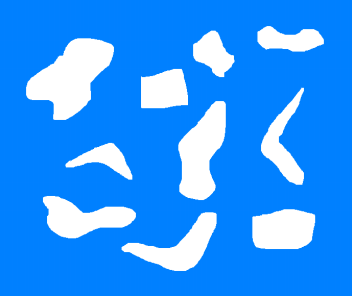

- Giả sử chúng ta muốn xác định tất cả các hình dạng boomerang và sau đó chặn chúng mà không sử dụng bất kỳ hình ảnh mẫu nào. Như bạn có thể thấy, có nhiều hình dạng kỳ lạ khác trong hình ảnh đó và hình dạng boomerang không thực sự trơn tru. 
- Chúng ta cần xác định thuộc tính sẽ phân biệt hình dạng boomerang với các hình dạng khác hiện có. Hãy xem xét thân tàu lồi. Nếu bạn lấy tỷ lệ diện tích của mỗi hình dạng với diện tích của thân lồi, chúng ta có thể thấy rằng đây có thể là một số liệu phân biệt. 
- Số liệu này được gọi là **yếu tố rắn(solidity factor)** trong phân tích hình dạng. Số liệu này sẽ có giá trị thấp hơn cho các hình dạng boomerang do khu vực trống sẽ bị bỏ lại, như trong hình sau:

- Các ranh giới màu đen đại diện cho bao lồi. Khi chúng ta tính toán các giá trị này cho tất cả các hình dạng, làm thế nào để chúng ta tách chúng ra ?
- Chúng ta có thể sử dụng một ngưỡng cố định để phát hiện các hình dạng boomerang không?
- Không hẳn vậy! Chúng ta không thể có giá trị ngưỡng cố định vì bạn không bao giờ biết loại hình nào bạn có thể gặp sau này. Vì vậy, một cách tiếp cận tốt hơn sẽ là sử dụng **phân cụm K-mean (K-mean clustering)**. K-mean là một kỹ thuật học tập không giám sát (unsupervising learning), có thể được sử dụng để phân tách dữ liệu đầu vào K lớp. Tham khảo thêm tại [đây](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html)
- Thuật toán K-mean clustering tại trang **machinelearningcoban.com**:
    + https://machinelearningcoban.com/2017/01/01/kmeans/
    + https://machinelearningcoban.com/2017/01/04/kmeans2/

- Chúng ta biết rằng chúng ta muốn tách các hình dạng thành hai nhóm, đó là hình dạng boomerang và các hình dạng khác. Vì vậy, chúng ta biết $K$ của chúng ta sẽ là gì trong K-mean.
- Khi chúng ta sử dụng giá trị đó và phân cụm các giá trị, chúng ta chọn cụm có hệ số độ rắn thấp nhất và điều đó sẽ cho chúng ta hình dạng boomerang. Hãy nhớ rằng phương pháp này chỉ hoạt động trong trường hợp cụ thể này. 
- Nếu bạn đang xử lý các loại hình dạng khác, thì bạn sẽ phải sử dụng một số số liệu khác để đảm bảo rằng shape detector hoạt động. 
- Như chúng ta đã thảo luận trước đó, nó phụ thuộc rất nhiều vào tình huống. Nếu bạn phát hiện các hình dạng và chặn chúng ra, nó sẽ trông như thế này:

- Sau đây là đoạn code để làm điều đó:

In [ ]:
import sys
import cv2
import numpy as np

if __name__=='__main__':
    # Input image containing all the shapes
    img = cv2.imread('shapes.png')
    
    img_orig = np.copy(img)
    input_contours = get_all_contours(img)
    solidity_values = []
    
    # Compute solidity factors of all the contours
    for contour in input_contours:
        area_contour = cv2.contourArea(contour)
        convex_hull = cv2.convexHull(contour)
        area_hull = cv2.contourArea(convex_hull)
        solidity = float(area_contour)/area_hull
        solidity_values.append(solidity)
    
    # Clustering using KMeans
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    solidity_values = np.array(solidity_values).reshape((len(solidity_values),1)).astype('float32')
    compactness, labels, centers = cv2.kmeans(solidity_values, 2, None, criteria, 10, flags)
    closest_class = np.argmin(centers)
    output_contours = []
    for i in solidity_values[labels==closest_class]:
        index = np.where(solidity_values==i)[0][0]
        output_contours.append(input_contours[index])
        
    cv2.drawContours(img, output_contours, -1, (0,0,0), 3)
    cv2.imshow('Output', img)
    
    # Censoring
    for contour in output_contours:
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(img_orig, [box], 0, (0,0,0), -1)
        
    cv2.imshow('Censored', img_orig)
    cv2.waitKey()

## 5. What is image segmentation?

- Phân đoạn hình ảnh (image segmentation) là quá trình tách một hình ảnh thành các bộ phận cấu thành của nó. Đây là một bước quan trọng trong nhiều ứng dụng thị giác máy tính trong thế giới thực.
- Có nhiều cách khác nhau để phân chia một hình ảnh. Khi chúng ta phân đoạn một hình ảnh, chúng ta sẽ phân tách các khu vực dựa trên các số liệu khác nhau, chẳng hạn như màu sắc, kết cấu, vị trí, v.v. 
- Tất cả các pixel trong mỗi khu vực đều có điểm chung, tùy thuộc vào số liệu chúng ta đang sử dụng. Chúng ta hãy xem một số phương pháp phổ biến ở đây.

- Để bắt đầu, chúng ta sẽ xem xét một kỹ thuật có tên **GrabCut**. Đây là một phương pháp phân đoạn hình ảnh dựa trên cách tiếp cận chung hơn gọi là **cắt đồ thị (graph-cuts)**. 
- Trong phương pháp cắt **đồ thị (graph-cuts)**, chúng ta coi toàn bộ hình ảnh là một đồ thị và sau đó chúng ta phân đoạn đồ thị dựa trên cường độ của các đường nét trong biểu đồ đó. 
- Chúng ta xây dựng đồ thị bằng cách coi mỗi pixel là một nút (node) và các cạnh được xây dựng giữa các nút, trong đó trọng số cạnh là một hàm của các giá trị pixel của hai nút đó. Bất cứ khi nào có một ranh giới, các giá trị pixel cao hơn. Do đó, trọng lượng cạnh cũng sẽ cao hơn. Biểu đồ này sau đó được phân đoạn bằng cách giảm thiểu năng lượng Gibbs của biểu đồ. Điều này tương tự với việc tìm phân đoạn entropy tối đa. Bạn có thể tham khảo bài báo gốc để tìm hiểu thêm về nó tại [đây](http://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf)

- Hãy quan sát hình ảnh dưới đây:

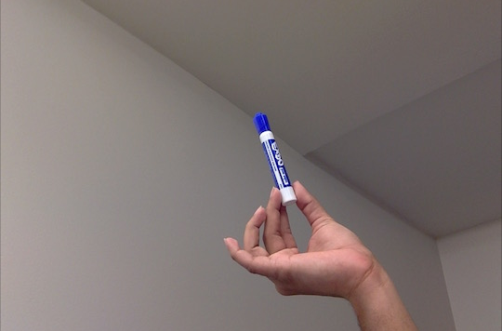

- Hãy chọn vùng quan tâm:

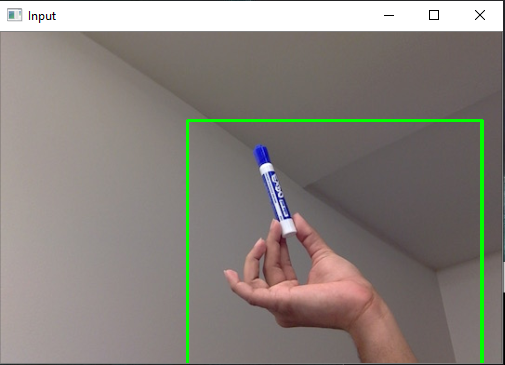

- Khi hình ảnh đã được phân đoạn, nó sẽ trông giống như thế này:

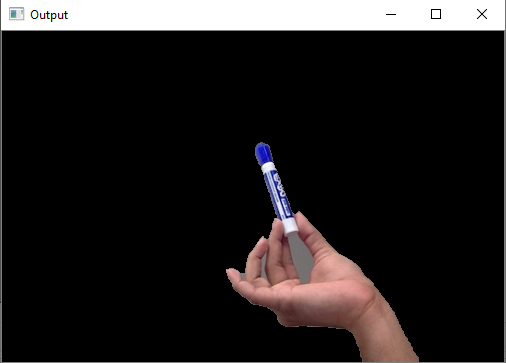

In [2]:
import sys
import cv2
import numpy as np

# Draw rectangle based on the input selection
def draw_rectangle(event, x, y, flags, params):
    global x_init, y_init, drawing, top_left_pt, bottom_right_pt, img_orig
    # Detecting mouse button down event
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        x_init, y_init = x, y
        
    # Detecting mouse movement
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            top_left_pt, bottom_right_pt = (x_init,y_init), (x,y)
            img[y_init:y, x_init:x] = 255 - img_orig[y_init:y, x_init:x]
            cv2.rectangle(img, top_left_pt, bottom_right_pt, (0,255,0), 2)
            
    # Detecting mouse button up event
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        top_left_pt, bottom_right_pt = (x_init,y_init), (x,y)
        img[y_init:y, x_init:x] = 255 - img[y_init:y, x_init:x]
        cv2.rectangle(img, top_left_pt, bottom_right_pt, (0,255,0), 2)
        rect_final = (x_init, y_init, x-x_init, y-y_init)
        
        # Run Grabcut on the region of interest
        run_grabcut(img_orig, rect_final)
    
# Grabcut algorithm
def run_grabcut(img_orig, rect_final):
    # Initialize the mask
    mask = np.zeros(img_orig.shape[:2],np.uint8)
    
    # Extract the rectangle and set the region of
    # interest in the above mask
    x,y,w,h = rect_final
    mask[y:y+h, x:x+w] = 1
    
    # Initialize background and foreground models
    bgdModel = np.zeros((1,65), np.float64)
    fgdModel = np.zeros((1,65), np.float64)
    
    # Run Grabcut algorithm
    cv2.grabCut(img_orig, mask, rect_final, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    
    # Extract new mask
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    
    # Apply the above mask to the image
    img_orig = img_orig*mask2[:,:,np.newaxis]
    
    # Display the image
    cv2.imshow('Output', img_orig)
    
if __name__=='__main__':
    drawing = False
    top_left_pt, bottom_right_pt = (-1,-1), (-1,-1)
    # Read the input image
    img_orig = cv2.imread('pen.png')
    img = img_orig.copy()
    cv2.namedWindow('Input')
    cv2.setMouseCallback('Input', draw_rectangle)
    while True:
        cv2.imshow('Input', img)
        c = cv2.waitKey(1)
        if c == 27:
            break
    cv2.destroyAllWindows()

### How does it work?

- Chúng ta bắt đầu với các điểm giống được chỉ định bởi người dùng. Đây là bouding box trong đó chứa đối tượng quan tâm.
- Về bản chất, thuật toán ước tính phân bố màu của đối tượng và nền. Thuật toán đại diện cho phân phối màu của hình ảnh dưới dạng **Gaussian Mixture Markov Random Field (GMMRF)**. Bạn có thể tham khảo bài viết chi tiết để tìm hiểu thêm về GMMRF, tại [đây](https://www.microsoft.com/en-us/research/publication/interactive-image-segmentation-using-an-adaptive-gmmrf-model/?from=http%3A%2F%2Fresearch.microsoft.com%2Fpubs%2F67898%2Feccv04-gmmrf.pdf)

- Chúng ta cần phân phối màu của cả đối tượng và nền, bởi vì chúng ta sẽ sử dụng "kiến thức" này để phân tách đối tượng. Thông tin này được sử dụng để tìm phân đoạn entropy tối đa bằng cách áp dụng thuật toán min-cut vào Markov Random Field. Khi chúng ta đạt được điều này, chúng ta sử dụng phương pháp tối ưu hóa đồ thị cắt (graph-cut) để suy ra nhãn.

## 6. Watershed algorithm

- OpenCV đi kèm với việc triển khai mặc định các thuật toán Watershed, tại https://docs.opencv.org/trunk/d3/db4/tutorial_py_watershed.html theo lý thuyết nói rằng bất kỳ hình ảnh thang độ xám nào cũng có thể được xem như một bề mặt địa hình nơi cường độ cao biểu thị các đỉnh và đồi, trong khi cường độ thấp biểu thị các thung lũng. Thuật toán này khá nổi tiếng và có rất nhiều triển khai có sẵn.

- Hãy xem hình ảnh sau:

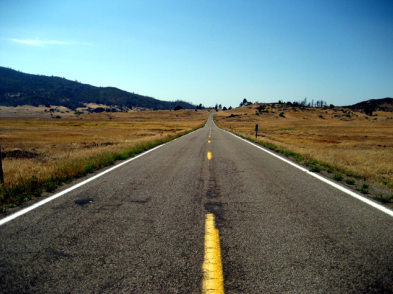

- Hãy chọn các vùng tùy thuộc vào bề mặt địa hình của chúng:

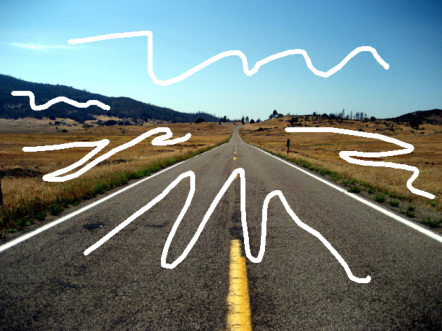

- Nếu bạn chạy thuật toán Watershed với input là ảnh trên, đầu ra sẽ trông giống như thế này:

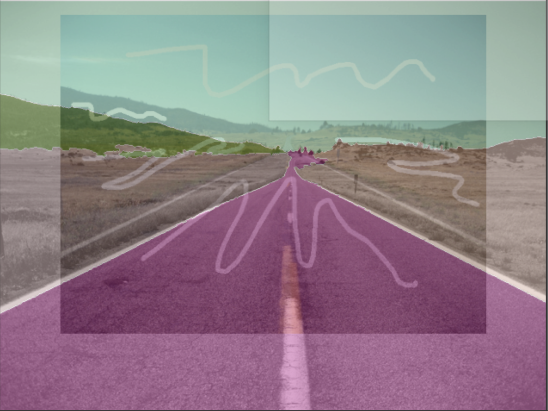

- Code mẫu có thể được tìm thấy trên liên kết được đưa ra ở trên, cùng với nhiều ứng dụng khác của thuật toán Watershed.

## Kết luận

- Trong chương này, chúng ta đã tìm hiểu về phân tích đường viền và phân đoạn hình ảnh.
- Chúng ta đã học cách so khớp các hình dạng dựa trên một mẫu. 
- Chúng ta đã tìm hiểu về các tính chất khác nhau của hình dạng và cách chúng ta có thể sử dụng chúng để xác định các loại hình dạng khác nhau.
- Chúng ta đã thảo luận về phân đoạn hình ảnh và cách chúng ta có thể sử dụng các phương pháp dựa trên đồ thị để phân đoạn các vùng trong một hình ảnh.
- Chúng tôi thảo luận ngắn gọn về chuyển đổi Watershed.
- **Trong chương tiếp theo, chúng ta sẽ thảo luận về cách theo dõi một đối tượng (`tracking object`) trong video trực tiếp.**